In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
from typing import Sequence
import os

import mechafil.data as mecha_data
from datetime import date, timedelta
import datetime

import matplotlib.pyplot as plt
import numpy as np

import jax
import jax.numpy as jnp
from jax import random, vmap
from jax.scipy.special import logsumexp
from jax import random

import optax
from jaxopt import OptaxSolver
from jaxopt import objective

import flax.linen as nn

import mechafil_jax.data as data
import mechafil_jax.sim as sim
import mechafil_jax.constants as C

import cel_utils.disk_utils as du

from tqdm.auto import tqdm

In [3]:
start_date = date(2021, 3, 15)
current_date = date.today() - timedelta(days=2)

In [4]:
auth_token_fp = '/Users/kiran/code/filecoin-mecha-twin/kiran_spacescope_auth.json'
offline_data = 'offline'
os.makedirs(offline_data, exist_ok=True)

In [5]:
# setup data from starboard
mecha_data.setup_spacescope(auth_token_fp)
stats_df = mecha_data.spacescope_obj.query_spacescope_supply_stats(start_date, current_date)

In [6]:
# generate all data needed to run model
forecast_length = 1
end_date = current_date + timedelta(days=forecast_length)
    
offline_data = data.get_simulation_data(auth_token_fp, start_date, current_date, end_date)

In [7]:
# static inputs
forecast_length = 1
sector_duration = 360

# these are noops
rbp_val = 6
rr_val = 0.6
fpr_val = 0.6
rbp = jnp.ones(forecast_length) * rbp_val
rr = jnp.ones(forecast_length) * rr_val
fpr = jnp.ones(forecast_length) * fpr_val
lock_target=0.3

simulation_results = sim.run_sim(
    rbp,
    rr,
    fpr,
    lock_target,

    start_date,
    current_date,
    forecast_length,
    sector_duration,
    offline_data
)

In [8]:
# setup dataset
y = stats_df['locked_fil'].values / 1.0e6
X = np.asarray([
    simulation_results['network_RBP_EIB'],
    simulation_results['network_QAP_EIB'],
    simulation_results['network_baseline_EIB'],
    simulation_results['circ_supply'] / 1.0e6,
    simulation_results['network_locked'] / 1.0e6
]).T

In [9]:
# perform a train/test split
ix = np.random.permutation(X.shape[0])
train_pct = 0.8
num_train = int(X.shape[0] * train_pct)
X_train = X[0:num_train,:]
y_train = y[0:num_train]
X_test = X[num_train:]
y_test = y[num_train:]

<IPython.core.display.Javascript object>


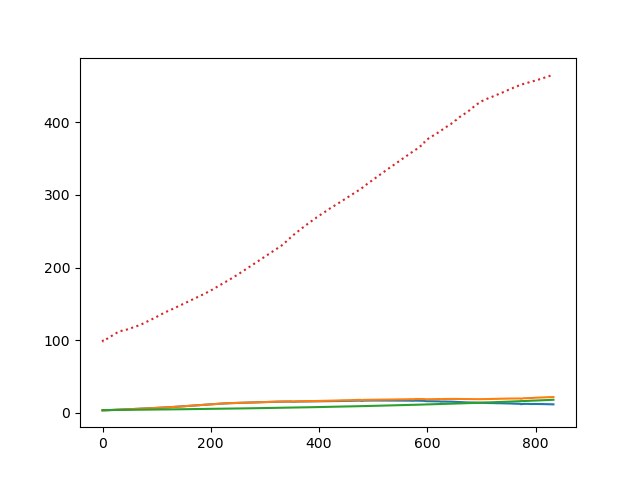

In [10]:
plt.figure()
plt.plot(X[:,0])
plt.plot(X[:,1])
plt.plot(X[:,2])
plt.plot(X[:,3], linestyle=':')

In [11]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(667, 5) (667,) (167, 5) (167,)


In [12]:
class RegressionModel(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(16)(x)
        x = nn.relu(x)
        x = nn.Dense(1)(x)
        return x

In [13]:
# TODO: revisit
num_features = 5

model = RegressionModel()
batch = jnp.ones((1, num_features))
init_params = model.init(jax.random.PRNGKey(0), batch)

In [14]:
def ridge_reg_objective(params, l2reg, data):
    X, y = data
    preds = model.apply(params, X)
    residuals = preds - y
    #w = jnp.concatenate((params['params']['Dense_0']['kernel'].flatten(), params['params']['Dense_1']['kernel'].flatten()))
    #print(jnp.mean(residuals**2).numpy(), jnp.sum(w**2).numpy())#, 
    #print(jnp.mean(residuals**2)/(0.5*l2reg*jnp.sum(w**2)))
    return jnp.mean(residuals ** 2) # + 0.5 * l2reg * jnp.sum(w ** 2)

In [15]:
# Define a function to generate data on the fly
batch_size = 64
def data_iterator():
    key = random.PRNGKey(1)
    while True:
        key, subkey = random.split(key)
        
        # TODO: keep the structure of the data
        
        perm = random.permutation(subkey, num_train)[:batch_size]
        yield (X_train[perm], y_train[perm])
        
def loss_fn(params):
    X_batch, y_batch = next(data_generator())
    return ridge_reg_objective(params, X_batch, y_batch)

In [16]:
lr = 1e-3
l2reg=0.1
maxiter=1000
opt = optax.adam(lr)
solver = OptaxSolver(opt=opt, fun=ridge_reg_objective, maxiter=maxiter)

In [17]:
iterator = data_iterator()
state = solver.init_state(init_params, l2reg=l2reg)
params = init_params
error_tracking = np.zeros(maxiter)
for ii in tqdm(range(maxiter)):
    data = next(iterator)
    params, state = solver.update(params, state, l2reg=l2reg, data=data)
    error_tracking[ii] = state.error

  0%|          | 0/1000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


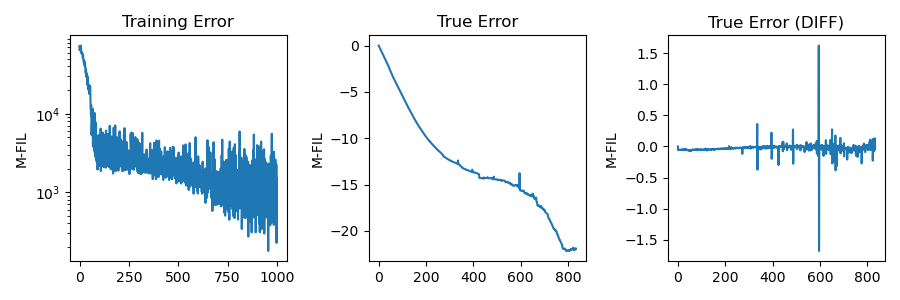

In [22]:
plt.figure(figsize=(9,3))

plt.subplot(1,3,1)
plt.plot(error_tracking)
plt.title('Training Error')
plt.ylabel('M-FIL')
plt.yscale('log')

err = y - X[:,4]
plt.subplot(1,3,2)
plt.plot(err)
plt.title('True Error')
plt.ylabel('M-FIL')

plt.subplot(1,3,3)
plt.plot(np.diff(err, prepend=err[0]))
plt.title('True Error (DIFF)')
plt.ylabel('M-FIL')


plt.tight_layout()

<IPython.core.display.Javascript object>


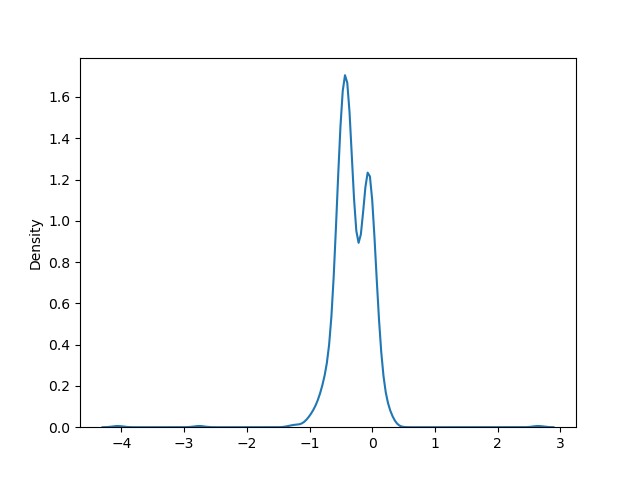

<Axes: ylabel='Density'>

In [19]:
true_err = y-X[:,3]
import seaborn as sns

plt.figure()
sns.kdeplot(np.diff(true_err))

In [20]:
rbp = simulation_results['network_RBP_EIB'][:-1]
qap = simulation_results['network_QAP_EIB'][:-1]
baseline = simulation_results['network_baseline_EIB'][:-1]
cs = simulation_results['circ_supply'][:-1] / 1.0e6,
locked_M = simulation_results['network_locked'][:-1] / 1e6
X_pred = jnp.vstack((rbp, qap, baseline, cs, locked_M)).T
l = len(locked_M)
locked_true = jnp.array(stats_df['locked_fil'].iloc[-l:].values / 1e6)
y_pred = model.apply(params, X_pred)

<IPython.core.display.Javascript object>


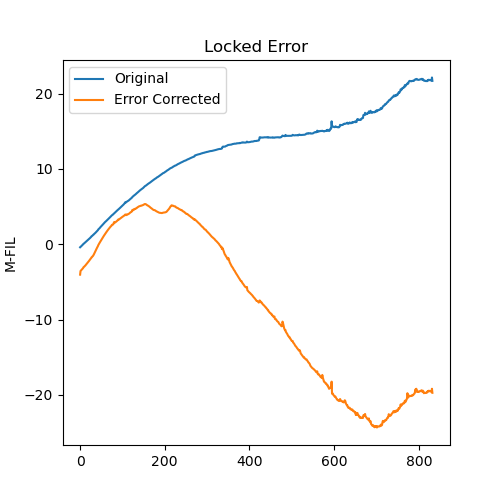

In [21]:
plt.figure(figsize=(5,5))
plt.plot(locked_M-locked_true, label='Original')
plt.plot(y_pred.squeeze()-locked_true, label='Error Corrected')
plt.ylabel('M-FIL')
plt.title('Locked Error')
plt.legend()